<a href="https://colab.research.google.com/github/shgupta1461/Big-Data-Lab/blob/main/BDP_Assignment5_202318052.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   **Name:** Shubham Gupta
*   **Student Id:** 202318052

**BIG DATA PROCESSING (Assignment 5)** Machine Learning using PySpark

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=1636bc8e7f04dfd1f6c6a3c88a4589127078e8bd77d0820998a235332e7b09ea
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


**1. Setup and Data Preparation**

In [21]:
from pyspark.sql import SparkSession

In [22]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("NewsPopularityPrediction") \
    .getOrCreate()

# Load the Online News Popularity dataset into a PySpark DataFrame
data = spark.read.csv("/content/OnlineNewsPopularity.csv", header=True, inferSchema=True)

# Display the schema to understand the structure of the dataset
data.printSchema()

root
 |-- url: string (nullable = true)
 |--  timedelta: double (nullable = true)
 |--  n_tokens_title: double (nullable = true)
 |--  n_tokens_content: double (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: double (nullable = true)
 |--  num_self_hrefs: double (nullable = true)
 |--  num_imgs: double (nullable = true)
 |--  num_videos: double (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: double (nullable = true)
 |--  data_channel_is_lifestyle: double (nullable = true)
 |--  data_channel_is_entertainment: double (nullable = true)
 |--  data_channel_is_bus: double (nullable = true)
 |--  data_channel_is_socmed: double (nullable = true)
 |--  data_channel_is_tech: double (nullable = true)
 |--  data_channel_is_world: double (nullable = true)
 |--  kw_min_min: double (nullable = true)
 |--  kw_max_min: do

**2. Data Preprocessing**

In [23]:
# Drop irrelevant features such as URL data
data = data.drop("url")

# Deal with missing values
data = data.dropna()

# Convert the target variable (shares) into binary outcome
median_shares = data.approxQuantile(" shares", [0.5], 0.01)[0]
data = data.withColumn("popularity", (data[" shares"] >= median_shares).cast("integer"))

**3. Exploratory Data Analysis (EDA)**

In [24]:
# Analyze characteristics of popular and non-popular articles
data.groupBy("popularity").count().show()

# Analyze distribution of key features
data.describe().show()

+----------+-----+
|popularity|count|
+----------+-----+
|         1|21154|
|         0|18490|
+----------+-----+

+-------+------------------+------------------+------------------+------------------+-----------------+-------------------------+------------------+------------------+-----------------+------------------+---------------------+------------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------------------+--------------------------+---------------------------+-------------------+-------------------+---------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-

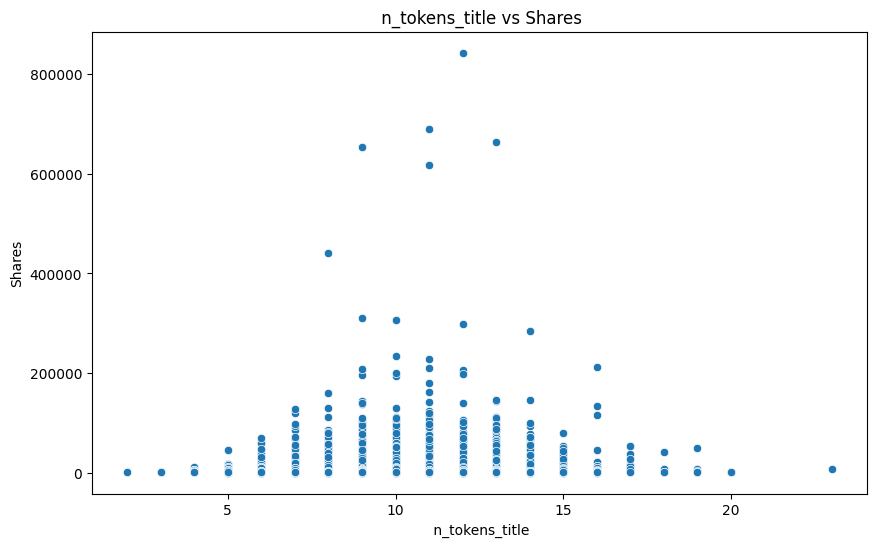

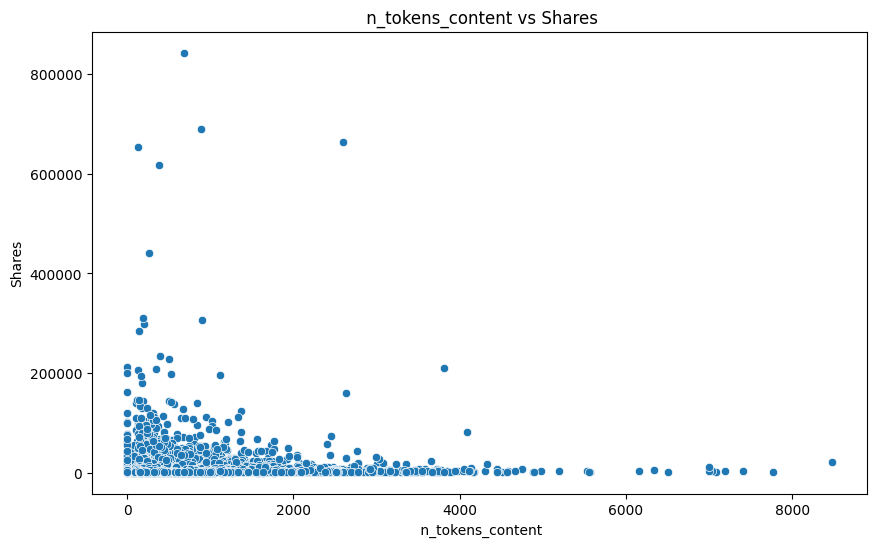

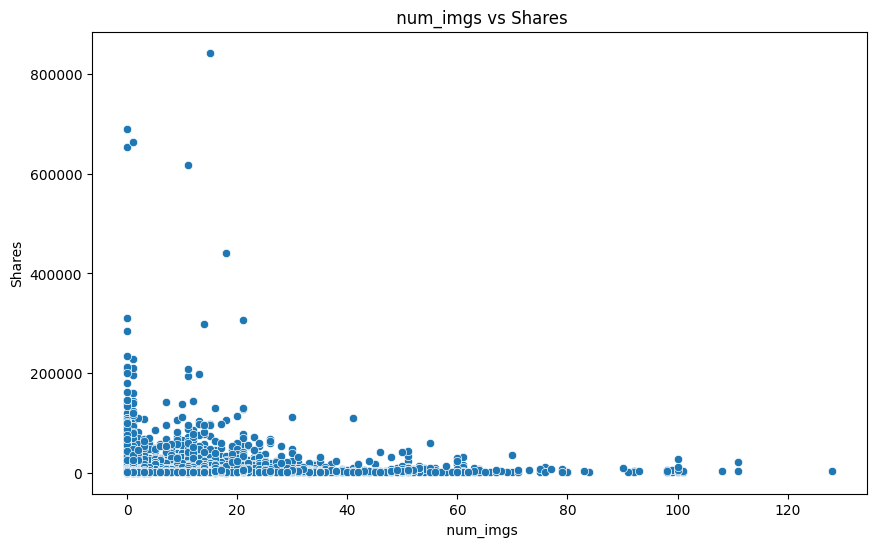

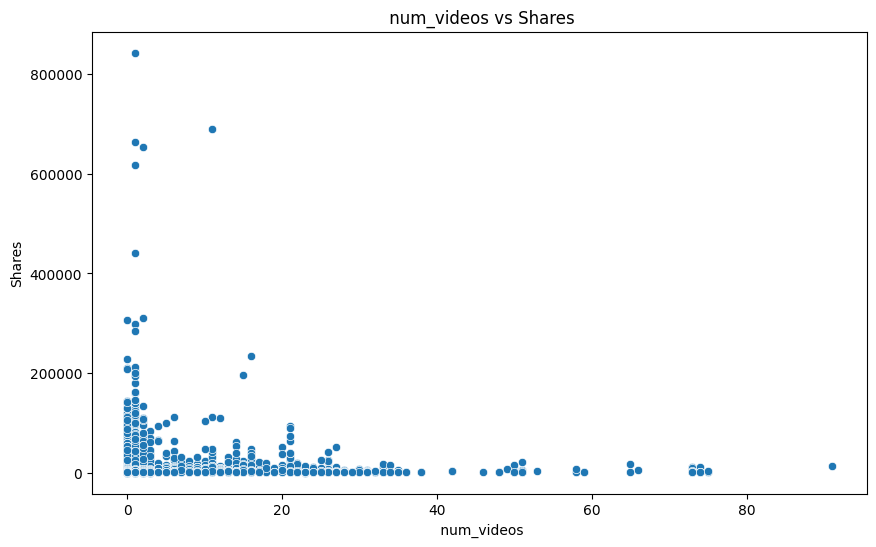

In [31]:
# Additional Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Relationship between shares and other numerical features
numeric_features = [" n_tokens_title", " n_tokens_content", " num_imgs", " num_videos"]

for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data.toPandas(), x=feature, y=" shares")
    plt.title(f"{feature} vs Shares")
    plt.xlabel(feature)
    plt.ylabel("Shares")
    plt.show()

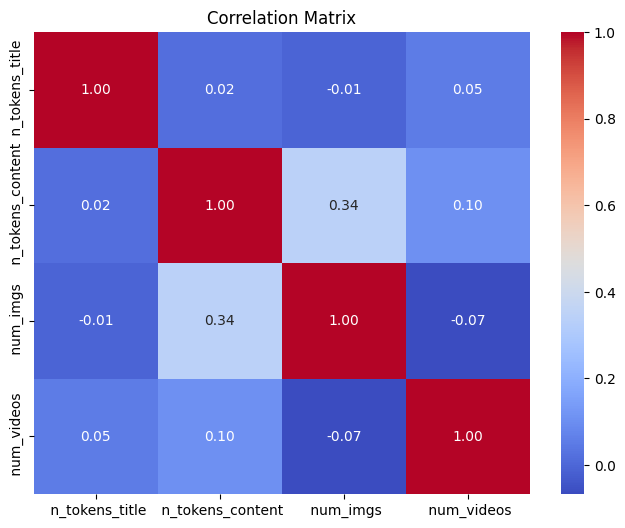

In [28]:
# Correlation matrix
numeric_data = data.select(numeric_features)
correlation_matrix = numeric_data.toPandas().corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

**4. Feature Engineering**

In [29]:
# Create new features
# Example: Article length categories
from pyspark.ml.feature import Bucketizer

bucketizer = Bucketizer(splits=[0, 500, 1000, float('inf')], inputCol=" n_tokens_content", outputCol="article_length_cat")
data = bucketizer.transform(data)

**5. Model Building**

In [30]:
# Split dataset into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Train a classification model (e.g., Logistic Regression)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

#  Create a feature vector
feature_cols = [col for col in data.columns if col not in [" shares", "popularity"]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Initialize the model
lr = LogisticRegression(featuresCol="features", labelCol="popularity")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Train the model
model = pipeline.fit(train_data)

**6.  Model Evaluation**

In [32]:
# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="popularity")
accuracy = evaluator.evaluate(predictions)

# Print evaluation metrics
print("Accuracy:", accuracy)

# Analyze the confusion matrix
predictions.groupBy("popularity", "prediction").count().show()

Accuracy: 0.7096623634154411
+----------+----------+-----+
|popularity|prediction|count|
+----------+----------+-----+
|         1|       0.0| 1248|
|         0|       0.0| 2235|
|         1|       1.0| 2901|
|         0|       1.0| 1441|
+----------+----------+-----+



**7. Advanced Analysis (ENSEMBLE METHODS)**

In [33]:
# Feature importance analysis
coefficients = model.stages[-1].coefficients
feature_importance = [(feature_cols[i], coefficients[i]) for i in range(len(feature_cols))]
print("Feature Importance:")
for feature, importance in feature_importance:
    print(feature, importance)

Feature Importance:
 timedelta -1.7751853751820122e-05
 n_tokens_title 0.005129467697928589
 n_tokens_content 0.00013586923650321783
 n_unique_tokens -0.21970427589021843
 n_non_stop_words 0.4781705494492787
 n_non_stop_unique_tokens -0.517783027189959
 num_hrefs 0.008771563290944159
 num_self_hrefs -0.016698734806955058
 num_imgs 0.001817847887692864
 num_videos -0.00035406069047767884
 average_token_length -0.09703006521835046
 num_keywords 0.044104140994508274
 data_channel_is_lifestyle -0.16236812723085756
 data_channel_is_entertainment -0.31513078476505557
 data_channel_is_bus -0.2110647501841119
 data_channel_is_socmed 0.8077175902448742
 data_channel_is_tech 0.4967558817577519
 data_channel_is_world 0.06992784763411362
 kw_min_min 0.0017711988079969728
 kw_max_min 2.573897711663453e-05
 kw_avg_min -0.000222309895544721
 kw_min_max -7.355438838191567e-07
 kw_max_max -4.075132040734127e-07
 kw_avg_max -5.495735574670244e-07
 kw_min_avg -8.554755932897333e-05
 kw_max_avg -8.6871009

In [34]:
# Grid search for parameter tuning
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Run cross-validation
cv_model = crossval.fit(train_data)
best_model = cv_model.bestModel
best_accuracy = evaluator.evaluate(best_model.transform(test_data))
print("Best Accuracy after tuning:", best_accuracy)

Best Accuracy after tuning: 0.7076655727575455


In [35]:
# Example: Ensemble method (Random Forest)
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="popularity")
pipeline_rf = Pipeline(stages=[assembler, rf])
model_rf = pipeline_rf.fit(train_data)
predictions_rf = model_rf.transform(test_data)
accuracy_rf = evaluator.evaluate(predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.6945455805520743


In [36]:
# Stop Spark session
spark.stop()